# Sample from trained two-dimensional model

If you want to try 2D morse potential, replace `log_p_dist` to `log_p_morse`.

In [1]:
import math

from tqdm.auto import tqdm

import numpy as np
import torch
from torch import Tensor


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


from moldiv.twodim import ScoreModel, sample_x_and_logP, log_p_dist
from moldiv.util import get_beta_i

## Visualize true distribution

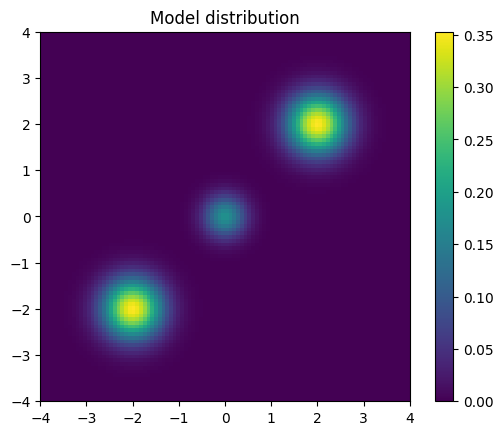

In [2]:
r = np.linspace(-4, 4, 100)
x0, x1 = np.meshgrid(r, r)
x = torch.tensor(np.vstack([x0.flatten(), x1.flatten()]).T)

log_p = log_p_dist(x)
# log_p = log_p_morse(x)
p = torch.exp(log_p)
plt.title("Model distribution")
plt.pcolormesh(x0, x1, p.reshape(x0.shape), cmap="viridis")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.colorbar()
plt.show()

## Load trained model

In [4]:
model = ScoreModel()
with open(f"result_gauss/snapshot_iter_12800", "rb") as checkpoint_file:
    checkpoint = torch.load(checkpoint_file, map_location="cpu", weights_only=False)
model.load_state_dict(checkpoint["models"]["main"])
device = "cuda:0"
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False

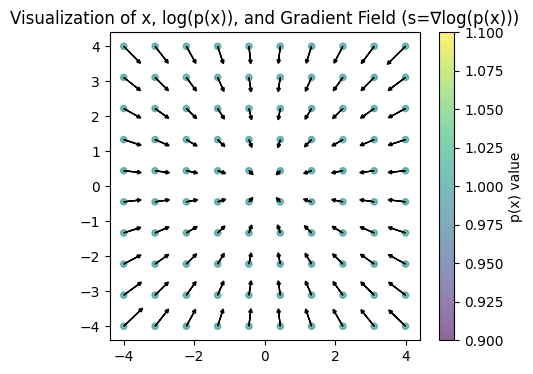

In [5]:
def visualize(x, p, s):
    plt.figure(figsize=[5, 4])
    plt.scatter(x[:, 0], x[:, 1], c=p, alpha=0.6, s=20)

    for i in range(len(x)):
        plt.arrow(
            x[i, 0],
            x[i, 1],
            s[i, 0] * 0.1,
            s[i, 1] * 0.1,
            head_width=0.1,
            head_length=0.1,
            fc="k",
            ec="k",
        )

    plt.colorbar(label="p(x) value")
    plt.title("Visualization of x, log(p(x)), and Gradient Field (s=∇log(p(x)))")
    plt.show()


r = np.linspace(-4, 4, 10)
x0, x1 = np.meshgrid(r, r)
x = torch.tensor(np.vstack([x0.flatten(), x1.flatten()]).T)
t = torch.ones(x.shape[0])
s, _ = model(x.to(device).to(torch.float32), t.to(device).to(torch.float32))
visualize(x, t, s.detach().to("cpu"))

## Visualize trained score

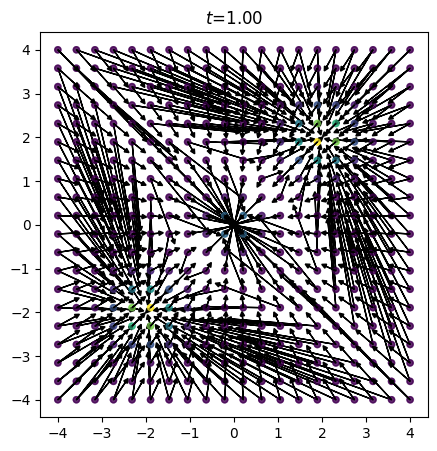

In [6]:
def gif_arrow(model):
    r = np.linspace(-4, 4, 20)
    x0, x1 = np.meshgrid(r, r)

    def update(t, x, p, model, T):
        if t != 0:
            plt.cla()
        plt.scatter(x[:, 0], x[:, 1], c=p, alpha=0.6, s=20)

        time = torch.ones(x.shape[0]) * (1.0 - t / (T - 1))
        s, _ = model(x.to(device).to(torch.float32), time.to(device).to(torch.float32))

        s = s.detach().to("cpu")
        for k in range(len(x)):
            plt.arrow(
                x[k, 0],
                x[k, 1],
                s[k, 0] * 0.1,
                s[k, 1] * 0.1,
                head_width=0.1,
                head_length=0.1,
                fc="k",
                ec="k",
            )
        plt.title(f"$t$={1.0-t/(T-1):.2f}")

    x = torch.tensor(np.vstack([x0.flatten(), x1.flatten()]).T)
    log_p = log_p_dist(x)
    # log_p = log_p_morse(x)
    p = torch.exp(log_p)
    T = 30
    fig = plt.figure(figsize=(5, 5))
    ani = animation.FuncAnimation(
        fig,
        update,
        fargs=(
            x,
            p,
            model,
            T,
        ),
        frames=T,
        interval=100,
    )
    ani.save("score-gauss-mixture.gif", writer="imagemagick")
    return ani

ani = gif_arrow(model)

![](score-gauss-mixture.gif)

## Structure generation

At first, one generates structure by stochastic differential equation (SDE);

$$
\mathbf{x}_N \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

$$
\mathbf{x}_{i-1} = \frac{1}{\sqrt{1-\beta_i}}\left(\mathbf{x}_{i} + \beta_i \mathbf{s}^{\theta}
(\mathbf{x}_i, t_i)\right)
+ \mathcal{N}(\mathbf{0}, \beta_i\mathbf{I})
$$

In [7]:
def sample_sde(n_sample: int, model: torch.nn.Module, device: str = "cuda:0") -> Tensor:
    N = model.N
    h = 1 / N
    x_i = torch.randn(n_sample, 2, device=device)
    t_ones = torch.ones(n_sample, device=device)
    β = get_beta_i(N)
    for i in tqdm(range(N, 0, -1)):
        t = i * h
        β_i = β[i]
        time = t * t_ones
        score, _ = model(x_i, time)
        x_i = (x_i + β_i * score) / math.sqrt(1 - β_i) + torch.randn(
            n_sample, 2, device=device
        ) * math.sqrt(β_i)
    return x_i

In [8]:
samples_pred = sample_sde(1000, model)

  0%|          | 0/500 [00:00<?, ?it/s]

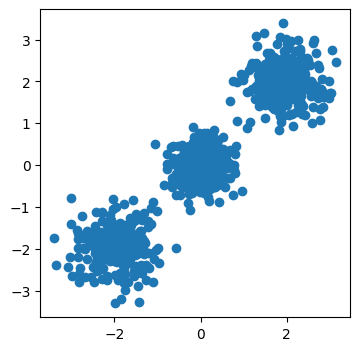

In [9]:
samples_pred_cpu = samples_pred.detach().to("cpu")

plt.figure(figsize=[4, 4])
plt.scatter(samples_pred_cpu[:, 0], samples_pred_cpu[:, 1])
plt.show()

Generate structure by ordinary differential equation (ODE)
$$
\mathrm{d} \mathbf{x}_t=
-\frac{\beta_t}{2}\left[\mathbf{x}_t+\mathbf{s}^\theta\left(\mathbf{x}_t, t\right)\right] \mathrm{d} t
$$

In [10]:
def sample_ode(n_sample: int, model: torch.nn.Module, device: str = "cuda:0") -> Tensor:
    N = model.N
    x_i = torch.randn(n_sample, 2, device=device)
    dt = -1.0 / N
    h = 1.0 / N
    t_ones = torch.ones(n_sample, device=device)
    β = get_beta_i(N)
    for i in tqdm(range(N, 0, -1)):
        t = i * h
        β_i = β[i]
        time = t * t_ones
        score, _ = model(x_i, time)
        β_t = β_i / h
        x_i += -(x_i + score) * β_t / 2.0 * dt
    return x_i

In [11]:
samples_pred = sample_ode(1000, model)

  0%|          | 0/500 [00:00<?, ?it/s]

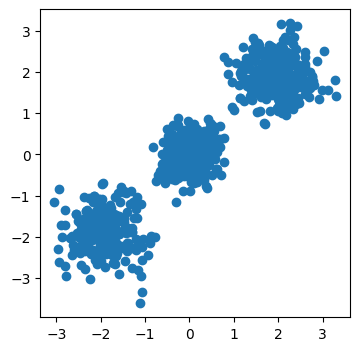

In [12]:
samples_pred_cpu = samples_pred.detach().to("cpu")

plt.figure(figsize=[4, 4])
plt.scatter(samples_pred_cpu[:, 0], samples_pred_cpu[:, 1])
plt.show()

Sample by ODE & caluculate corresponding probability by 

$$
\log p^\theta
\left(\mathbf{x}_0\right)=
\log \mathcal{N}\left(\mathbf{x}_{t=\tau}^\theta\left(\mathbf{x}_0\right);\mathbf{0}, \mathbf{I}\right)
-\int_0^{\tau} \frac{\beta_t}{2} \nabla \cdot \mathbf{s}^\theta\left(\mathbf{x}_{t}^\theta\left(\mathbf{x}_0\right), t\right) \mathrm{d} t-
\frac{D}{2} \int_0^{\tau} \beta_t \mathrm{~d} t
$$

  0%|          | 0/500 [00:00<?, ?it/s]

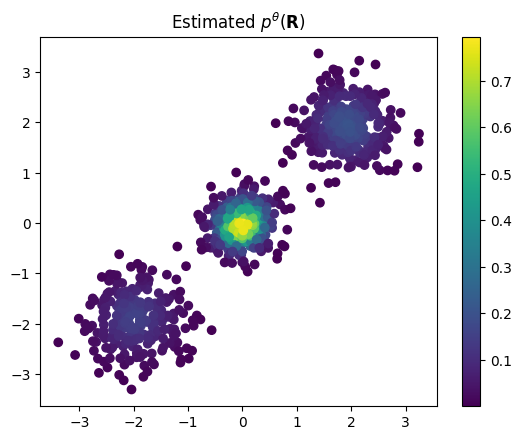

In [13]:
x, logP = sample_x_and_logP(1000, model)
x = x.to("cpu")
logP = logP.to("cpu")
plt.title(r"Estimated $p^\theta(\mathbf{R})$")
plt.scatter(x[:, 0], x[:, 1], c=torch.exp(logP))
plt.colorbar()
plt.show()

Compared with actual histgram

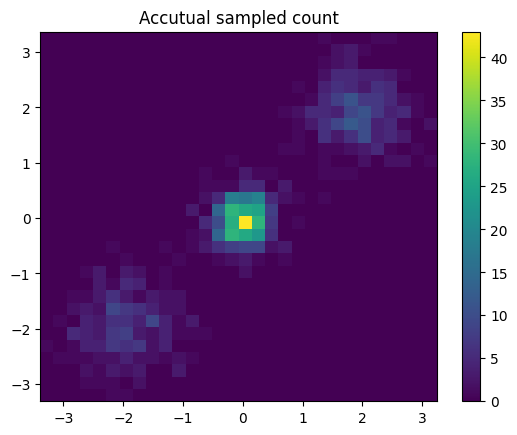

In [14]:
plt.title(r"Accutual sampled count")
plt.hist2d(x[:, 0], x[:, 1], bins=30)
plt.colorbar()
plt.show()

## Monte-Carlo Integral of $Z$

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

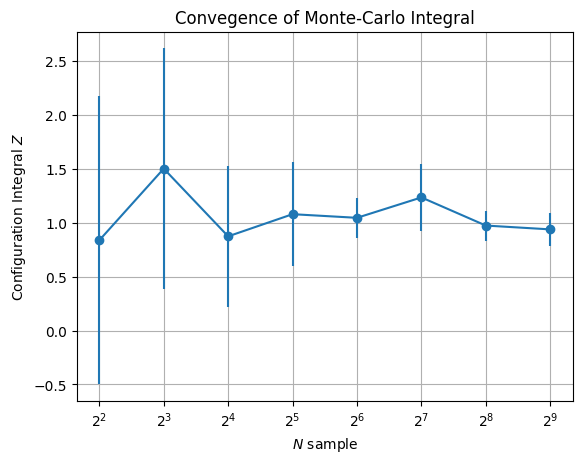

In [16]:
N_list = [4, 8, 16, 32, 64, 128, 256, 512]
n_shot = 10
Z_list = [[] for _ in range(len(N_list))]
for i, N in enumerate(N_list):
    x, log_p_theta = sample_x_and_logP(N * n_shot, model)
    for i_shot in range(n_shot):
        x_shot = x[i_shot * N : (i_shot + 1) * N]
        log_p_theta_shot = log_p_theta[i_shot * N : (i_shot + 1) * N]
        Z = torch.mean(torch.exp(log_p_dist(x_shot)) / torch.exp(log_p_theta_shot))
        Z_list[i].append(Z.to("cpu"))

Z_mean = [Z[0] for Z in Z_list]
Z_std = [3.0 * np.std(Z) for Z in Z_list]
plt.errorbar(N_list, Z_mean, yerr=Z_std, fmt="o-")
plt.xlabel("$N$ sample")
plt.ylabel("Configuration Integral $Z$")
plt.title("Convegence of Monte-Carlo Integral")
plt.xscale("log", base=2)
plt.grid(True)
plt.show()

## Numerical integral VS Monte-Carlo integral

In [18]:
Z_num = []
for n in N_list:
    r = np.linspace(-4, 4, math.isqrt(n))
    x0, x1 = np.meshgrid(r, r)
    x = torch.tensor(np.vstack([x0.flatten(), x1.flatten()]).T)
    dτ = ((4 - (-4)) / math.isqrt(n)) ** 2
    Z = torch.sum(torch.exp(log_p_dist(x))) * dτ
    # Z = torch.sum(torch.exp(log_p_morse(x))) * dτ
    Z_num.append(Z)

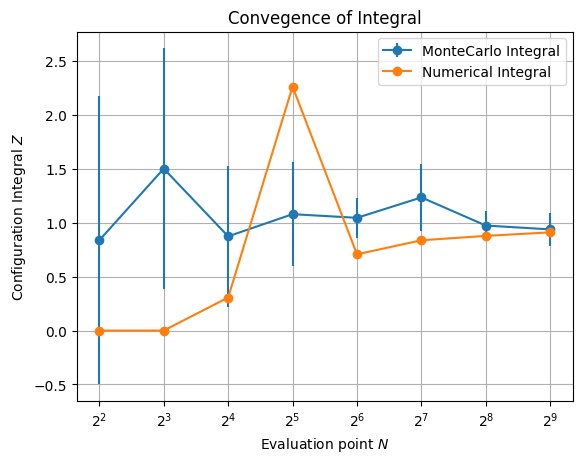

In [19]:
plt.errorbar(N_list, Z_mean, yerr=Z_std, fmt="o-", label="MonteCarlo Integral")
plt.errorbar(N_list, Z_num, fmt="o-", label="Numerical Integral")
plt.xlabel("Evaluation point $N$")
plt.ylabel("Configuration Integral $Z$")
plt.title("Convegence of Integral")
plt.xscale("log", base=2)
plt.grid(True)
plt.legend()
plt.show()